In [21]:
# fit a straight line with outlyers
# Hogg

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# from scipy.stats import laplace, norm
from numpy import log, exp, pi as π, sqrt, abs, sum, inf, full, cos
from numba import njit

In [23]:
# Generate noisy data with outliers
np.random.seed(42)

N = 100
noise = np.random.normal(0, 1, size=N)

m_t = 2.5
b_t = 1.0

x_data = np.linspace(0, 10, N)
y_data = m_t * x_data + b_t + noise

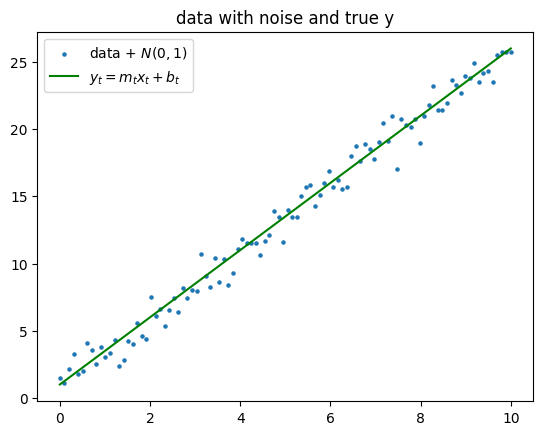

In [24]:
fig, ax = plt.subplots(1, 1)

ax.set(title="data with noise and true y")
ax.scatter(x_data, y_data, label="data + $N(0,1)$", s=5)
ax.plot(x_data, m_t*x_data + b_t, label=r"$y_t = m_t x_t + b_t$", c="g")

ax.legend()

In [25]:
# Add outliers
outliers_x = np.array([2, 5, 8])
outliers_y = np.array([20, 15, 30])
x_data_out = np.concatenate([x_data, outliers_x])
y_data_out = np.concatenate([y_data, outliers_y])

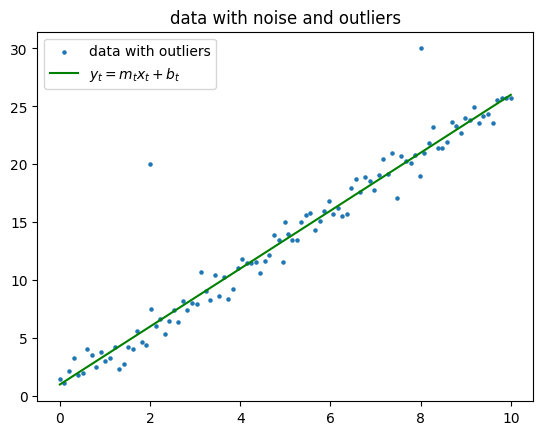

In [26]:
fig, ax = plt.subplots(1,1)
ax.set(title="data with noise and outliers")

ax.scatter(x_data_out, y_data_out, label="data with outliers", s=5)
ax.plot(x_data, m_t*x_data + b_t, label=r"$y_t = m_t x_t + b_t$", c="g")

ax.legend()

$$
N(x, μ, σ) = 
\frac{1}{\sqrt{2π}⋅σ} 
exp \left[
-\frac{(x-μ)^2}{2 σ^2}
\right]
$$

$$
Laplace(x, μ, b) =
\frac{1}{2b}
exp \left[
-\frac{|x-μ|}{b}
\right]
$$

In [27]:
@njit
def norm_pdf(x, μ, σ):
    a = 1 / (sqrt(2 * π) * σ)
    return a * exp(-((x - μ) ** 2) / (2 * σ**2))


@njit
def laplace_pdf(x, μ, b):
    a = 0.5 / b
    return a * exp(-abs(x - μ) / b)


$$
ℒ(m, b, x, y, σ_y, σ_{out}, p_{out}) = \\
∑log \left(        
    (1-p_{out}) norm(y, mx+b, σ_y) +  
    p_{out} laplace(y, mx+b, σ_{out})
\right)
$$

In [28]:
@njit
def likelihood(m, b, x, y, y_σ=1.0, out_σ=5.0, p_out=0.1):
    """likelihood mixture of 𝒩(inliers) and Laplace(outliers)."""
    y_m = m * x + b # model
    y_like = norm_pdf(y, μ=y_m, σ=y_σ)
    out_like = laplace_pdf(y, μ=y_m, b=out_σ)

    a1 = (1 - p_out) * y_like
    a2 = p_out * out_like
    return sum(log(a1 + a2))


$$
Prior(m, b) = [(-10 < m < 10) ∧ (-10 < b < 10)]:0:-∞
$$

In [29]:
@njit
def prior(m, b):
    """uniform prior"""
    cond = (-10 < m < 10) and (-10 < b < 10)
    # log(1) = 0, log(0) = -inf
    return 0 if cond else -inf


In [30]:
@njit
def posterior(m, b, x, y, y_sigma=1.0, out_sigma=5.0, p_out=0.1):
    """Posterior is proportional to likelihood * prior."""
    return prior(m, b) + likelihood(m, b, x, y, y_sigma, out_sigma, p_out)


In [40]:
@njit
def normal(μ, σ):
    """Box Muller Transform"""
    p = np.random.rand()
    q = np.random.rand()
    z = sqrt(-2 * log(p)) * cos(2 * π * q)
    return (z * σ) + μ

In [41]:
@njit
def MCMC(posterior, initial_params, x, y, steps=100_000, proposal_width=0.5):
    m, b = initial_params
    post = posterior(m, b, x, y)

    samples = full((steps, 2), np.nan)

    for i in range(steps):
        # proposals
        m_prop = normal(m, proposal_width)
        b_prop = normal(b, proposal_width)

        # posterior for proposed parameters
        post_prop = posterior(m_prop, b_prop, x, y)

        # Acceptance probability
        p_accept = np.exp(post_prop - post)

        # Accept or reject the proposal
        if np.random.rand() < p_accept:
            m, b = m_prop, b_prop
            post = post_prop

        # Store samples
        samples[i, :] = [m, b]

    return samples


In [42]:
# Run Metropolis-Hastings
initial_params = [0.0, 0.0]  # Initial guess for slope and intercept
samples = MCMC(
    posterior,
    initial_params,
    x_data_out,
    y_data_out,
)

# Plot the results
m_samples = samples[:, 0]
b_samples = samples[:, 1]

# 35 seconds... for 100k
# 9s numba

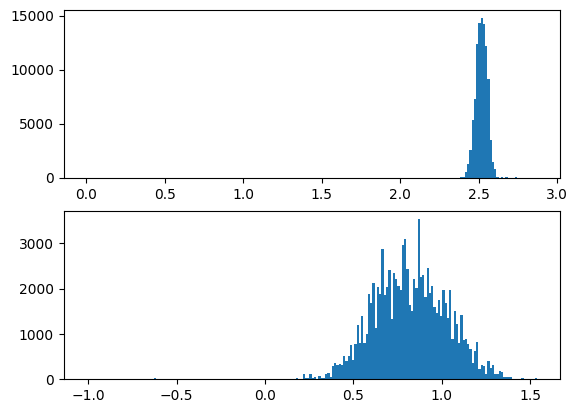

In [43]:
fig, [ax1, ax2] = plt.subplots(2, 1)

ax1.hist(m_samples, 200)
ax2.hist(b_samples, 200);

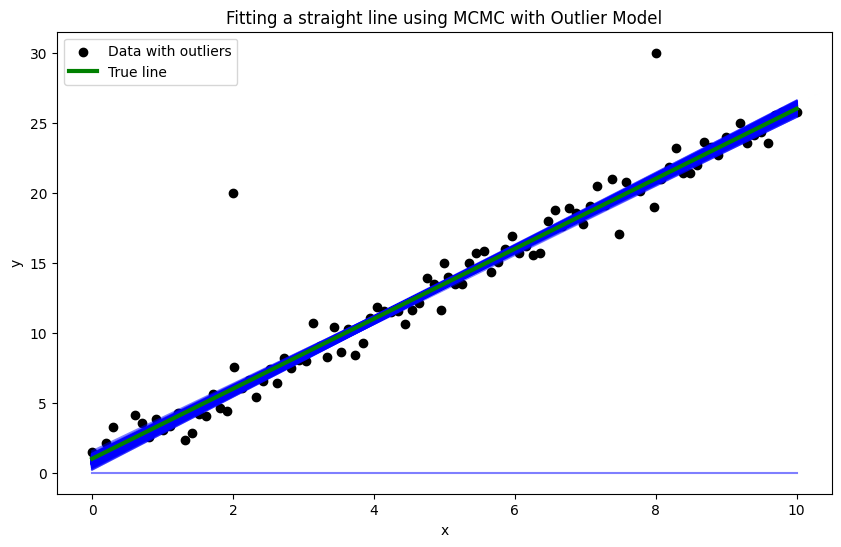

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set(
    title="Fitting a straight line using MCMC with Outlier Model",
    xlabel="x",
    ylabel="y",
)

# sampled lines
for i in range(0, len(samples), 200):
    ax.plot(x_data, m_samples[i] * x_data + b_samples[i], color="blue", alpha=0.5)

ax.scatter(x_data_out, y_data_out, label="Data with outliers", color="black")
ax.plot(x_data, m_t * x_data + b_t, label="True line", color="green", linewidth=3)


ax.legend()
